In [1]:
####################################################################################################
# CEE573.SnowHydro.Assignment3.ipynb
# Karl Lapo January/2016
####################################################################################################
# Surface Energy Balance assignment for Snow Hydrology
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph
import matplotlib.gridspec as gridspec

## Directory for the data
dir_data = '/Users/karllapo/gdrive/Teaching/DataExploration/Data'

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Read and format the data from Snoqualmie

In [2]:
##### Flux tower data
def parse(y, mo, dy, hr, mn):
    s = '00'
    date_str = y+':'+mo+':'+dy+'_'+hr+':'+mn+':'+s
    dt = datetime.strptime(date_str,"%Y:%m:%d_%H:%M:%S")
    return dt

# pandas read_csv (Dataframe)
os.chdir(dir_data+'/Snoqualmie')
datafile = 'SNQ_QC_30min.csv'
data = pd.read_csv(datafile,header=0,skiprows=[1,2],na_values=-9999,\
                   parse_dates={'Datetime' : [0,1,2,3,4]},date_parser=parse,index_col='Datetime')

# Convert to xray Dataset format for ease of processing
ds = xray.Dataset.from_dataframe(data)
ds = ds.rename({'Datetime': 'time'})

# Take a look at what we have
print(ds)

<xray.Dataset>
Dimensions:       (time: 46174)
Coordinates:
  * time          (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    JulianDay     (time) int64 275 275 275 275 275 275 275 275 275 275 275 ...
    T4            (time) float64 5.856 5.856 5.875 6.061 6.267 6.214 5.994 ...
    RH4           (time) float64 82.9 83.9 84.6 83.9 82.0 83.3 83.7 84.3 ...
    Precip        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SurfPres      (time) float64 1.028e+03 1.027e+03 1.027e+03 1.027e+03 ...
    WIND          (time) float64 0.068 0.126 0.06 0.1255 0.0455 0.0985 0.199 ...
    Snowdepth_24  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Snowdepth     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Lysimeter     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SW_down_avg   (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    SW_up_avg     (time) float64 nan nan nan nan na

In [3]:
## Daily averages and diurnal temperature range
ds_daily = xray.Dataset()
ds_daily = ds.resample(how='mean',freq='D',dim='time')
ds_daily['Tmin'] = ds['T4'].resample(how='min',freq='D',dim='time')
ds_daily['Tmax'] = ds['T4'].resample(how='max',freq='D',dim='time')
ds_daily['deltaT'] = ds_daily.Tmax-ds_daily.Tmin

## Let's take a look at some of this data


(-30, 1)

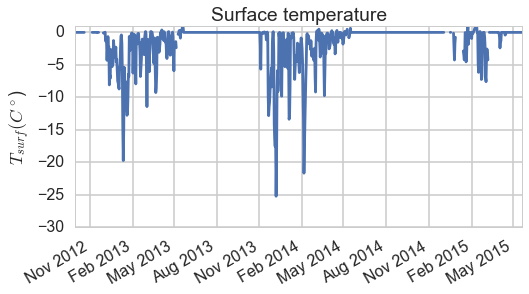

In [81]:
# Surface temperature
# Tsrf = (ds.Tsrf_1+ds.Tsrf_2)/2
Tsrf = ds.Tsrf_1
Tsrf[~(ds.Snowdepth > .01)] = 0
Tsrf = Tsrf.resample(how='mean',freq='D',dim='time')

fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(Tsrf.time,Tsrf)
ax.set_ylabel('$T_{surf} (C^\circ$)')
ax.set_title('Surface temperature')
fig.autofmt_xdate()
ax.set_ylim(-30,1)

In [70]:
## From: http://stackoverflow.com/questions/11564273/matplotlib-continuous-colormap-fill-between-two-lines
#Fill a contour between two lines
def rainbow_fill_between(ax, X, Y1, Y2, colors=None, 
                         cmap=plt.get_cmap("Reds"),**kwargs):
    ax.plot(X,Y2,lw=0)  # Plot so the axes scale correctly
    ax.plot(X,Y1,lw=0)  # Plot so the axes scale correctly

    dx = X[1]-X[0]
    N  = X.size

    #Pad a float or int to same size as x
    if (type(Y2) is float or type(Y2) is int):
        Y2 = np.array([Y2]*N)

    #No colors -- specify linear
    if colors is None:
        colors = []
        for n in range(N):
            colors.append(cmap(n/float(N)))
    #Varying only in x
    elif len(colors.shape) is 1:
        colors = cmap((colors-colors.min())
                      /(colors.max()-colors.min()))
    #Varying only in x and y
    else:
        cnp = np.array(colors)
        colors = np.empty([colors.shape[0],colors.shape[1],4])
        for i in range(colors.shape[0]):
            for j in range(colors.shape[1]):
                colors[i,j,:] = cmap((cnp[i,j]-cnp[:,:].min())
                                    /(cnp[:,:].max()-cnp[:,:].min()))

    colors = np.array(colors)
    #Create the patch objects
    for (color,x,y1,y2) in zip(colors,X,Y1,Y2):
        if y2-y1 > 0:
#             ax.add_patch(\
#                 matplotlib.patches.Rectangle((x,y1),dx,y2-y1,facecolor=color,edgecolor=color, **kwargs))
            ax.fill_between((x,x+dx),y1,y2,facecolor=color,edgecolor=color)


(735173.0, 735385.0)

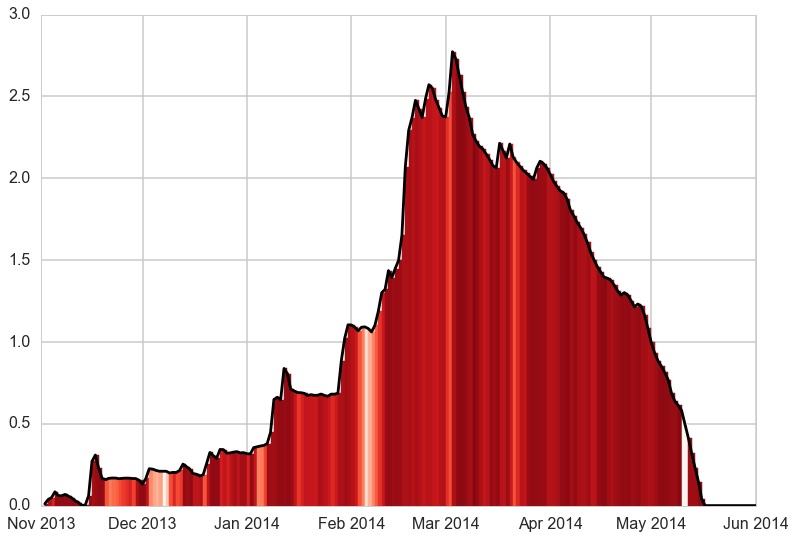

In [82]:
fig,ax1 = plt.subplots(1,1)

rainbow_fill_between(ax1, time, np.zeros_like(snowdepth), snowdepth,\
                         colors=Tsrf,
                         cmap=cm.Reds)
ax1.plot(time, snowdepth, 'k')
ax1.set_xlim(date1,date2)


(735173.0, 735385.0)

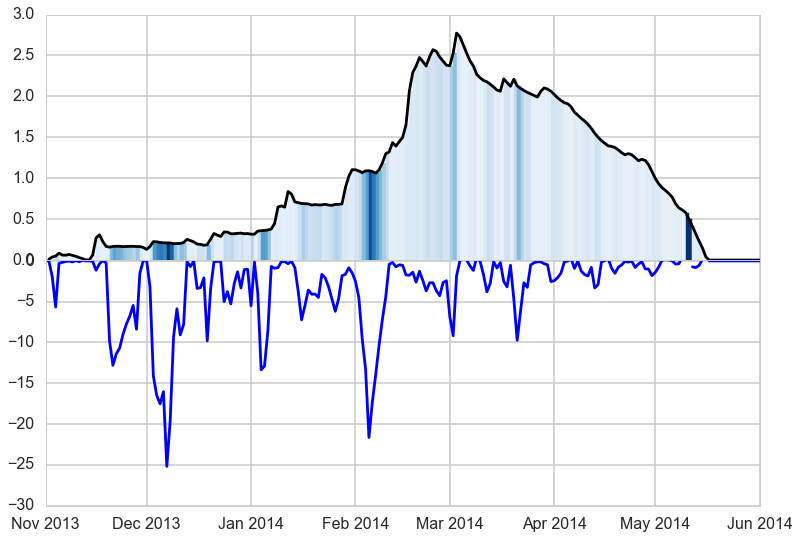

In [85]:
date1 = datetime(2013,11,1)
date2 = datetime(2014,6,1)

snowdepth = ds.Snowdepth.resample(how='mean',freq='D',dim='time').values

time = ds.resample(how='mean',freq='D',dim='time').time.values

gs1 = gridspec.GridSpec(2, 1)
gs1.update(hspace=0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[1, 0])

ax1.plot(time,snowdepth,'k')
rainbow_fill_between(ax1, time, np.zeros_like(snowdepth), snowdepth,\
                         colors=Tsrf,
                         cmap=cm.)
ax1.set_xlim(date1,date2)
ax1.set_xticklabels('')

ax2.plot(time,Tsrf,'b')
ax2.set_ylim(-30,0.1)
ax2.set_xlim(date1,date2)

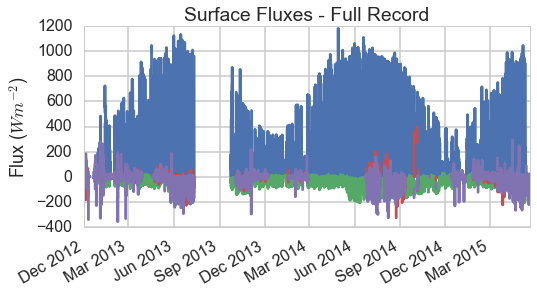

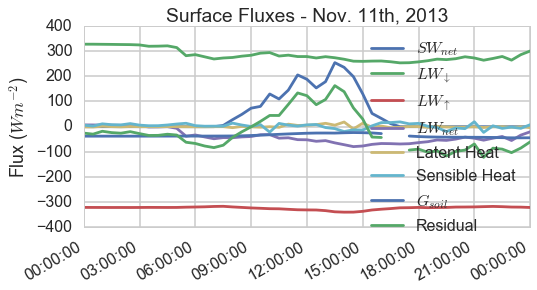

In [44]:


## Examine an individual day
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(ds.time,ds.SW_down_avg-ds.SW_up_avg,label='$SW_{net}$')
ax.plot(ds.time,ds.LW_down_avg,label='$LW_{\downarrow}$')
ax.plot(ds.time,-ds.LW_up_avg,label='$LW_{\uparrow}$')
ax.plot(ds.time,ds.LW_down_avg-ds.LW_up_avg,label='$LW_{net}$')
ax.plot(ds.time,ds.LatFlux,label='Latent Heat')
ax.plot(ds.time,ds.SensFlux,label='Sensible Heat')
ax.plot(ds.time,ds.GheatfluxAvg,label='$G_{soil}$')
ax.plot(ds.time, (ds.SW_down_avg-ds.SW_up_avg) + (ds.LW_down_avg - ds.LW_up_avg)\
        + ds.LatFlux + ds.SensFlux + ds.GheatfluxAvg,label='Residual')

# Format plot
ax.set_xlim(datetime(2013,11,11),datetime(2013,11,12))
ax.set_ylim(-400,400)
ax.set_ylabel('Flux ($Wm^{-2}$)')
ax.set_title('Surface Fluxes - Nov. 11th, 2013')
fig.autofmt_xdate()
ax.legend(loc='best')

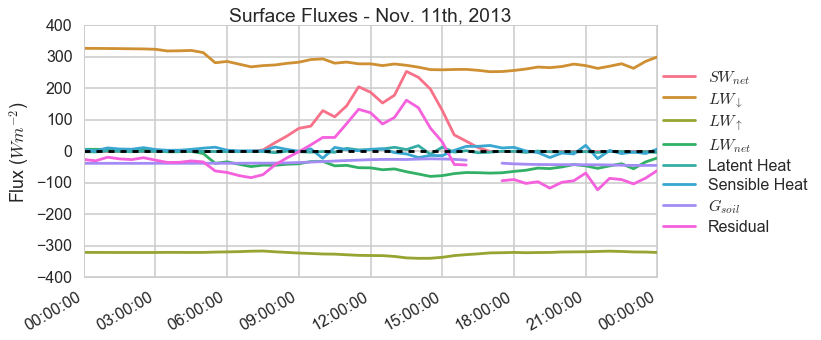

In [76]:
## Explore plotting routines
sns.set_palette("husl",8)
fig = plt.figure(figsize=(12,5))
gs = matplotlib.gridspec.GridSpec(1,2,width_ratios=np.array((8,1)))
gs.update(wspace=0.075)

ax = plt.subplot(gs[0,0])
ax.plot(ds.time,ds.SW_down_avg-ds.SW_up_avg,label='$SW_{net}$')
ax.plot(ds.time,ds.LW_down_avg,label='$LW_{\downarrow}$')
ax.plot(ds.time,-ds.LW_up_avg,label='$LW_{\uparrow}$')
ax.plot(ds.time,ds.LW_down_avg-ds.LW_up_avg,label='$LW_{net}$')
ax.plot(ds.time,ds.LatFlux,label='Latent Heat')
ax.plot(ds.time,ds.SensFlux,label='Sensible Heat')
ax.plot(ds.time,ds.GheatfluxAvg,label='$G_{soil}$')
ax.plot(ds.time, (ds.SW_down_avg-ds.SW_up_avg) + (ds.LW_down_avg - ds.LW_up_avg)\
        + ds.LatFlux + ds.SensFlux + ds.GheatfluxAvg,label='Residual')
handles, labels = ax.get_legend_handles_labels()
ax.plot([datetime(2013,11,11),datetime(2013,11,12)],[0,0],'k--')

# Format plot
ax.set_xlim(datetime(2013,11,11),datetime(2013,11,12))
ax.set_ylim(-400,400)
ax.set_ylabel('Flux ($Wm^{-2}$)')
ax.set_title('Surface Fluxes - Nov. 11th, 2013')
fig.autofmt_xdate()

# Legend
ax = plt.subplot(gs[0,1])
ax.axis('off')
ax.legend(handles, labels,loc='center',ncol=1,\
                    labelspacing=.25,markerscale=1,numpoints=1,\
                    bbox_to_anchor=(.5, .25, .5, .5))


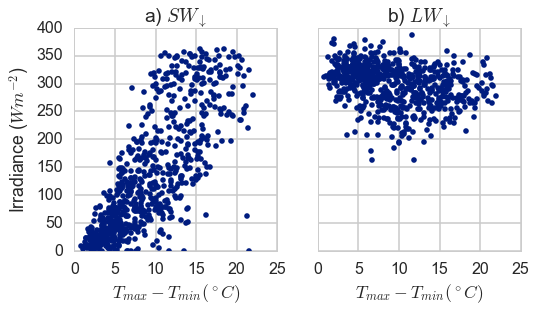

In [86]:
## Correlating variables
sns.set_palette("dark",8)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4),sharey=True)

ax1.plot(ds_daily.deltaT,ds_daily.SW_down_avg,'.')
ax2.plot(ds_daily.deltaT,ds_daily.LW_down_avg,'.')

ax1.set_title('a) $SW_{\downarrow}$')
ax2.set_title('b) $LW_{\downarrow}$')
ax1.set_ylabel('Irradiance ($Wm^{-2}$)')
ax1.set_xlabel('$T_{max} - T_{min} (^\circ C)$')
ax2.set_xlabel('$T_{max} - T_{min} (^\circ C)$')

Solar radiation has a much stronger relationship with the diurnal temperature range than longwave radiation. This makes sense when you consider the factors driving a large diurnal cycle in air temperature: 

1. clear daytime = more solar heating and warmer maximum air temperatures
2. clear night time = more longwave cooling and cooler minimum air temperatures 

## Correlate half-hour fluxes with surface temperature

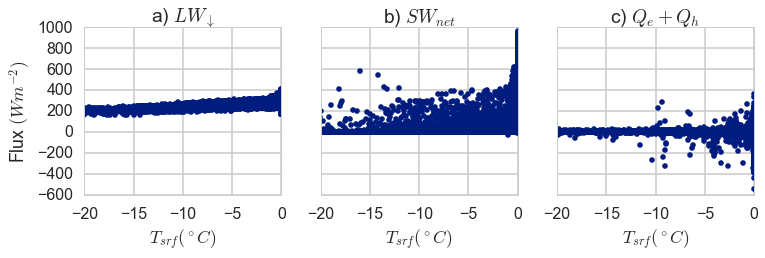

In [82]:
## 1/2 hour correlation with Ts
sns.set_palette("dark",8)
fig,axes = plt.subplots(1,3,figsize=(12,3),sharey=True)
axes[0].plot(ds.Tsrf_1,ds.LW_down_avg,'.')
axes[0].set_xlim(-20,0)
axes[1].plot(ds.Tsrf_1,ds.SW_down_avg-ds.SW_up_avg,'.')
axes[1].set_xlim(-20,0)
axes[2].plot(ds.Tsrf_1,ds.LatFlux+ds.SensFlux,'.')
axes[2].set_xlim(-20,0)

plotLabels=['a) $LW_{\downarrow}$','b) $SW_{net}$','c) $Q_e + Q_h$']
for n,ax in enumerate(axes):
    ax.set_title(plotLabels[n])
    ax.set_xlim(-20,0)
    ax.set_xlabel('$T_{srf} (^\circ C)$')
axes[0].set_ylabel('Flux $(Wm^{-2})$')

$LW_{\downarrow}$ has a much more linear correlation with surface temperature than net shortwave or net turbulence. But, $SW_{\downarrow}$ has a diurnal cycle, yielding a lot of '0' fluxes. What if we do the same exercise, but with daily averages?

## Correlate daily fluxes with surface temperature

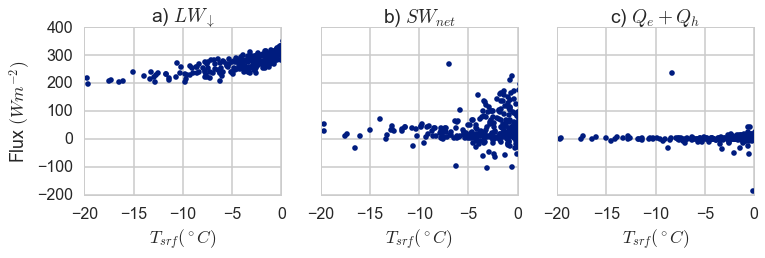

In [83]:
## Daily correlation with Ts
sns.set_palette("dark",8)
fig,axes = plt.subplots(1,3,figsize=(12,3),sharey=True)
axes[0].plot(ds_daily.Tsrf_1,ds_daily.LW_down_avg,'.')
axes[0].set_xlim(-20,0)
axes[1].plot(ds_daily.Tsrf_1,ds_daily.SW_down_avg-ds_daily.SW_up_avg,'.')
axes[1].set_xlim(-20,0)
axes[2].plot(ds_daily.Tsrf_1,ds_daily.LatFlux+ds_daily.SensFlux,'.')
axes[2].set_xlim(-20,0)

plotLabels=['a) $LW_{\downarrow}$','b) $SW_{net}$','c) $Q_e + Q_h$']
for n,ax in enumerate(axes):
    ax.set_title(plotLabels[n])
    ax.set_xlim(-20,0)
    ax.set_xlabel('$T_{srf} (^\circ C)$')
axes[0].set_ylabel('Flux $(Wm^{-2})$')

The linear relationship between $LW_{\downarrow}$ and surface temperature appears stronger, same with the relationship with net shortwave. Net turbulence clearly does not have a strong relationship with surface temperature. Something weird is going on with the net shortwave though: we have negative daily values! We should be careful using those data in the future given that behavior.

The negative net shortwave is being caused by snow accumulating on the uplooking sensor, shading of the uplooking pyranometer, and instrument failure. If you're curious about how to diagnose those sorts of data errors come talk to me! I have a number of methods that can be used to improve our confidence when using these sorts of questionable data.

In [70]:
## MATLAB files for in-class use
# Write to matlab datenum
def datetime2matlabdn(dt):
   ord = dt.toordinal()
   mdn = dt + timedelta(days = 366)
   frac = (dt-datetime(dt.year,dt.month,dt.day,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
   return mdn.toordinal() + frac

matlabTime = np.empty(ds.time.values.shape)
for n,dt in enumerate(ds.time.values):
    pdt = pd.Timestamp(dt)
    matlabTime[n] = datetime2matlabdn(pdt)
    
matlabTimeDaily = np.empty(ds_daily.time.values.shape)
for n,dt in enumerate(ds_daily.time.values):
    pdt = pd.Timestamp(dt)
    matlabTimeDaily[n] = datetime2matlabdn(pdt)

# Drop unused variables
ds = ds.drop(['SurfPres','JulianDay','Snowdepth_24','T6','Vap_press_6','RH6','T3','CSAT Height',\
             'CSAT Azimuth','GT_11','GT_21','GT_41','GT_3','VWC_3','VWC_11','VWC_21','VWC_37','Tsrf_2'])

# Remove surface temperatures greater than 0
ds['Tsrf'] = ds.Tsrf_1.sel(time=ds['Tsrf_1'] <= 0).reindex_like(ds)
ds = ds.drop(['Tsrf_1'])

# Rename some poorly named variables
ds = ds.rename({'T4':'Tair','RH4':'RH'})

## CSVs
# Daily (diurnal temperature and longwave/shortwave)
ds_daily.to_dataframe().to_csv(path_or_buf='SnoqualmeiFluxes.Daily.CEE573.csv',na_rep=-9999)
# 1/2 hourly
ds.to_dataframe().to_csv(path_or_buf='SnoqualmieFluxes.HalfHour.CEE573.csv',na_rep=-9999)

## Matlab files
import scipy.io as sio
# Half hourly
SWdwn = ds.SW_down_avg.values
sio.savemat('SWdwn_HalfHour_SNQ.mat', {'SWdwn':SWdwn})
SWup = ds.SW_up_avg.values
sio.savemat('SWup_HalfHour_SNQ.mat', {'SWup':SWup})
LWdwn = ds.LW_down_avg.values
sio.savemat('LWdwn_HalfHour_SNQ.mat', {'LWdwn':LWdwn})
LWup = ds.LW_up_avg.values
sio.savemat('LWup_HalfHour_SNQ.mat', {'LWup':LWup})
sensHeat = ds.SensFlux.values
sio.savemat('sensHeat_HalfHour_SNQ.mat', {'sensHeat':sensHeat})
latHeat = ds.LatFlux.values
sio.savemat('latHeat_HalfHour_SNQ.mat', {'latHeat':latHeat})
Tsrf = ds.Tsrf.values
sio.savemat('Tsurf_HalfHour_SNQ.mat', {'Tsurf':Tsrf})
sio.savemat('matlabTime_HalfHour_SNQ.mat', {'time':matlabTime})

# Daily
SWdwnDaily = ds_daily.SW_down_avg.values
sio.savemat('SWdwn_Daily_SNQ.mat', {'SWdwnDaily':SWdwnDaily})
LWdwnDaily = ds_daily.LW_down_avg.values
sio.savemat('LWdwn_Daily_SNQ.mat', {'SWdwnDaily':LWdwnDaily})
diurnalTemp = ds_daily.deltaT.values
sio.savemat('diurnalTemp_Daily_SNQ.mat', {'diurnalTemp':diurnalTemp})
sio.savemat('matlabTime_Daily_SNQ.mat', {'timeDaily':matlabTimeDaily})